## Diagnostics for approximate likelihood ratios

Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016.

This is an extension of the example in [Parameterized inference from multidimensional data](./Parameterized%20inference%20from%20multidimensional%20data.ipynb). 
To aid in visualization, we restrict to a 1-dimensional slice of
the likelihood along $\alpha$ with $\beta=-1$.   We consider three situations: i)
a poorly trained, but well calibrated classifier; ii) a well trained, but poorly
calibrated classifier; and iii) a well trained, and well calibrated classifier.
For each case, we employ two diagnostic tests. The first checks for independence
of $-2\log\Lambda(\theta)$ with respect to changes in the reference value
$\theta_1$. The second uses a
classifier to distinguish between samples from  $p(\mathbf{x}|\theta_0)$ and
samples from $p(\mathbf{x}|\theta_1)$ weighted according to $r(\mathbf{x};
\theta_0, \theta_1)$. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.set_cmap("viridis")

import numpy as np
import theano
from scipy.stats import chi2
from itertools import product

np.random.seed(314)

Couldn't import dot_parser, loading of dot files will not be possible.


Create model and generate artificial dataset

In [2]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

import pdb

# Parameters
true_A = 1.
A = theano.shared(true_A, name="A")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=A, sigma=1),
        Normal(mu=-1, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Define p1 at fixed arbitrary value A=0
p1s = []
p1_params = [(0,-1),(1,-1),(0,1)]
for p1_p in p1_params:
    p1s.append(LinearTransform(Join(components=[
        Normal(mu=p1_p[0], sigma=1),
        Normal(mu=p1_p[1], sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R))
p1 = p1s[0]
# Draw data
X_true = p0.rvs(500, random_state=314) 

# Known likelihood setup

In [3]:
# Minimize the exact LR
from scipy.optimize import minimize
p1 = p1s[2]
def nll_exact(theta, X):
    A.set_value(theta[0])
    return (p0.nll(X) - p1.nll(X)).sum()

r = minimize(nll_exact, x0=[0], args=(X_true,))
exact_MLE = r.x

print("Exact MLE =", exact_MLE)

('Exact MLE =', array([ 1.01185166]))


In [4]:
# Exact LR
A.set_value(true_A)
nlls = []
As_ = []
bounds = [(true_A - 0.30, true_A + 0.30)]
As = np.linspace(bounds[0][0],bounds[0][1], 100)
nll = [nll_exact([a], X_true) for a in As]
nll = np.array(nll)
nll = 2. * (nll - r.fun)

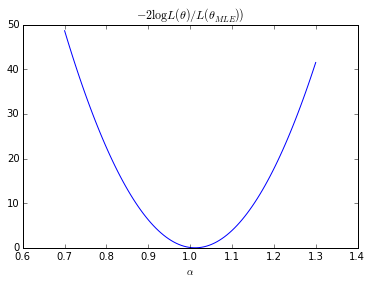

In [5]:
plt.plot(As, nll)
plt.xlabel(r"$\alpha$")
plt.title(r"$-2 \log L(\theta) / L(\theta_{MLE}))$")
plt.show()

# Likelihood-free setup
Here we create the data to train a parametrized classifier

In [6]:
# Build classification data
from carl.learning import make_parameterized_classification

bounds = [(-3, 3), (-3, 3)]

clf_parameters = [(1000,100000),(1000000,500),(1000000,100000)]
X = [0]*3*3
y = [0]*3*3



for k,(param,p1) in enumerate(product(clf_parameters,p1s)):
    X[k], y[k] = make_parameterized_classification(
        p0, p1,
        param[0], 
        [(A, np.linspace(bounds[0][0],bounds[0][1], num=30))],
        random_state=0)


In [7]:
# Train parameterized classifier
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
clfs = []
for k,_ in enumerate(product(clf_parameters,p1s)):
    clfs.append(ParameterizedClassifier(
        make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(40, 40),
                                             tol=1e-6,
                                             random_state=0))),
        [A]))
    clfs[k].fit(X[k], y[k])

/Users/juanpavez/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func,n_samples,clf,p1):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i,n_samples=n_samples,clf=clf, p1=p1)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0, n_samples=100000, clf=clfs[0],p1=p1s[0]):    
    
    # Set parameter values   
    A.set_value(theta[0])
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    X0 = p0.rvs(n_samples=n_samples)
    X1 = p1.rvs(n_samples=n_samples, random_state=random_state)
    X = np.vstack((X0, X1))
    y = np.zeros(len(X))
    y[len(X0):] = 1

    ratio.fit(X, y)
    
    # Evaluate log-likelihood ratio
    r = ratio.predict(X_true, log=True)
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)    
            
    return value

Now we use a Bayesian optimization procedure to create a smooth surrogate of the approximate likelihood.

In [9]:
from GPyOpt.methods import BayesianOptimization
solvers = []
for k,(param,p1) in enumerate(product(clf_parameters,p1s)):
    clf = clfs[k]
    n_samples = param[1]
    bounds = [(-3, 3)]
    solvers.append(BayesianOptimization(vectorize(objective,n_samples,clf,p1), bounds))
    solvers[k].run_optimization(max_iter=50, true_gradients=False)

*Optimization completed:
   -Maximum number of iterations reached.
*Optimization completed:
   -Maximum number of iterations reached.
*Optimization completed:
   -Maximum number of iterations reached.
*Optimization completed:
   -Maximum number of iterations reached.
*Optimization completed:
   -Maximum number of iterations reached.
*Optimization completed:
   -Maximum number of iterations reached.
*Optimization completed:
   -Maximum number of iterations reached.
*Optimization completed:
   -Maximum number of iterations reached.
*Optimization completed:
   -Maximum number of iterations reached.


In [10]:
approx_MLEs = []
for k,_ in enumerate(product(clf_parameters,p1s)):
    solver = solvers[k]
    approx_MLE = solver.x_opt
    approx_MLEs.append(approx_MLE)
    print("Approx. MLE =", approx_MLE)

('Approx. MLE =', array([ 1.1567223]))
('Approx. MLE =', array([ 1.12968218]))
('Approx. MLE =', array([ 1.27133084]))
('Approx. MLE =', array([ 1.09549403]))
('Approx. MLE =', array([ 0.91981054]))
('Approx. MLE =', array([ 0.77314181]))
('Approx. MLE =', array([ 1.02540673]))
('Approx. MLE =', array([ 1.00016057]))
('Approx. MLE =', array([ 1.0148428]))


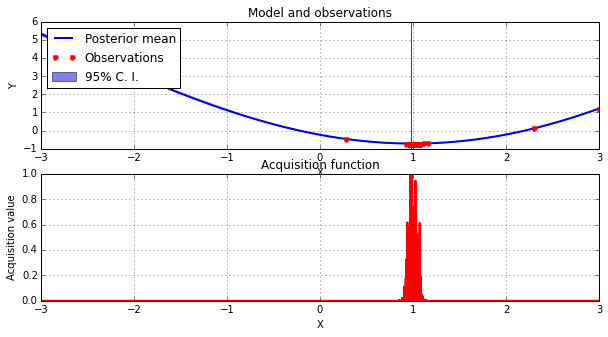

In [11]:
solver.plot_acquisition()

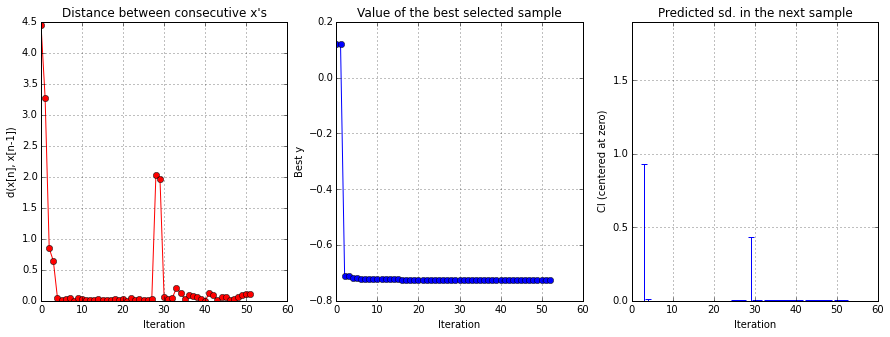

In [12]:
solver.plot_convergence()

In [13]:
# Minimize the surrogate GP approximate of the approximate LR
rs = []
solver = solvers[0]

for k,_ in enumerate(product(clf_parameters,p1s)):
    def gp_objective(theta):
        theta = theta.reshape(1, -1)
        return solvers[k].model.predict(theta)[0][0]

    r = minimize(gp_objective, x0=[0])
    rs.append(r)
    gp_MLE = r.x

    print("GP MLE =", gp_MLE)

('GP MLE =', array([ 1.15409679]))
('GP MLE =', array([ 1.13815972]))
('GP MLE =', array([ 1.25892465]))
('GP MLE =', array([ 1.03389187]))
('GP MLE =', array([ 0.93057811]))
('GP MLE =', array([ 0.7587189]))
('GP MLE =', array([ 1.01290299]))
('GP MLE =', array([ 1.00689144]))
('GP MLE =', array([ 0.99879448]))


In [14]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]

approx_ratios = []
gp_ratios = []
gp_std = []
gp_q1 = []
gp_q2 = []
n_points = 30

for k,(param,p1) in enumerate(product(clf_parameters,p1s)):
    clf = clfs[k]
    n_samples = param[1]
    solver = solvers[k]
    #As = np.linspace(*bounds[0], 100)
    nll_gp, var_gp = solvers[k].model.predict(As.reshape(-1, 1))
    nll_gp = 2. * (nll_gp - rs[k].fun) * len(X_true)
    gp_ratios.append(nll_gp)
    # STD
    std_gp = np.sqrt(4*var_gp*len(X_true)*len(X_true))
    std_gp[np.isnan(std_gp)] = 0.
    gp_std.append(std_gp)
    # 95% CI
    q1_gp, q2_gp = solvers[k].model.predict_quantiles(As.reshape(-1, 1))
    q1_gp = 2. * (q1_gp - rs[k].fun) * len(X_true)
    q2_gp = 2. * (q2_gp - rs[k].fun) * len(X_true)
    gp_q1.append(q1_gp)
    gp_q2.append(q2_gp)

    #nll_approx = np.zeros(n_points)

    #approx = [objective([a]) for a in np.linspace(*bounds[0], n_points)]
    #approx = [objective([a],n_samples=n_samples,clf=clf,p1=p1) for a 
    #          in np.linspace(bounds[0][0],bounds[0][1], n_points)]

    #approx = np.array(approx)
    #approx = 2. * (approx - approx.min()) * len(X_true)
    #nll_approx = approx
    #approx_ratios.append(nll_approx)


## Plots for the first diagonstic: $\theta_1$-independence

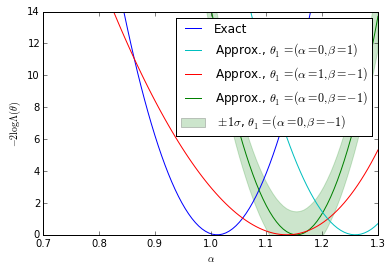

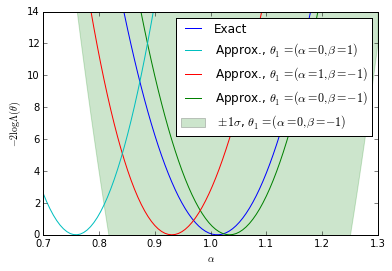

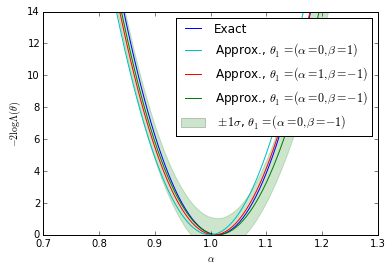

In [15]:
bounds = [(true_A - 0.30, true_A + 0.30)]
for k,_ in enumerate(clf_parameters):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(As, nll, label="Exact")
    #plt.plot(np.linspace(*bounds[0], n_points), nll_approx - , label="approx.")
    #plt.plot(np.linspace(bounds[0][0],bounds[0][1], n_points), nll_approx , label="approx.")
    ax.plot(As, gp_ratios[3*k], label=r"Approx., $\theta_1=(\alpha=0,\beta=-1)$")
    ax.plot(As, gp_ratios[3*k+1], label=r"Approx., $\theta_1=(\alpha=1,\beta=-1)$")
    ax.fill_between(As,(gp_ratios[3*k] - gp_std[3*k]).ravel(),(gp_ratios[3*k] + gp_std[3*k]).ravel(),
                     color='g',alpha=0.2)
    ax.plot(As, gp_ratios[3*k+2], label=r"Approx., $\theta_1=(\alpha=0,\beta=1)$")
    handles, labels = ax.get_legend_handles_labels()
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$-2 \log \Lambda(\theta)$")
    #plt.legend()
    p5 = plt.Rectangle((0, 0), 0.2, 0.2, fc="green",alpha=0.2,edgecolor='none')
    handles.insert(4,p5)
    labels.insert(4,r"$\pm 1 \sigma$, $\theta_1=(\alpha=0,\beta=-1)$")
    handles[1],handles[-2] = handles[-2],handles[1]
    labels[1],labels[-2] = labels[-2],labels[1]

    ax.legend(handles,labels)
    ax.set_ylim(0, 14)
    ax.set_xlim(bounds[0][0],bounds[0][1])
    plt.savefig('likelihood_comp_{0}.pdf'.format(k))
    plt.show()

We show the posterior mean of a Gaussian processes resulting
from Bayesian optimization of  the raw approximate likelihood. In addition, the standard deviation of the Gaussian process
is shown for one of the $\theta_1$ reference points to indicate the size of
these statistical fluctuations. It is clear that in the well calibrated cases
that these fluctuations are small, while in the poorly calibrated case these
fluctuations are large. Moreover, in the first case we see that in the poorly
trained, well calibrated case the classifier $\hat{s}(\mathbf{x}; \theta_0,
\theta_1)$ has a significant dependence on the $\theta_1$ reference point. In
contrast, in the second case the likelihood curves vary significantly, but
this is comparable to the fluctuations expected from the calibration procedure.
Finally, the third case shows that in the well trained, well calibrated case
that the likelihood curves are all consistent with the exact likelihood within
the estimated uncertainty band of the Gaussian process. 

## The second diagnostic - ROC curves for a discriminator

In [17]:
from sklearn.metrics import roc_curve, auc
def makeROC(predictions,targetdata):
    fpr, tpr, _  = roc_curve(targetdata.ravel(),predictions.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr,tpr,roc_auc

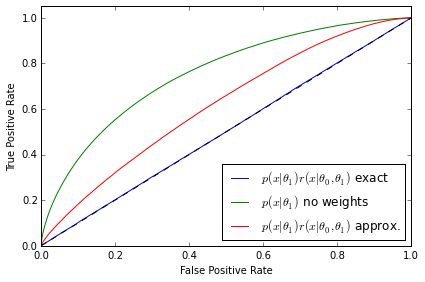

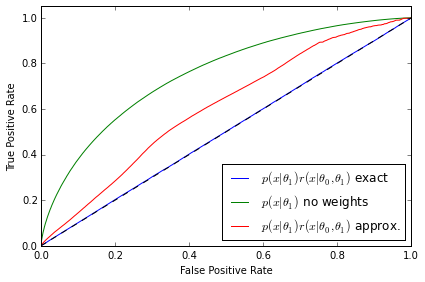

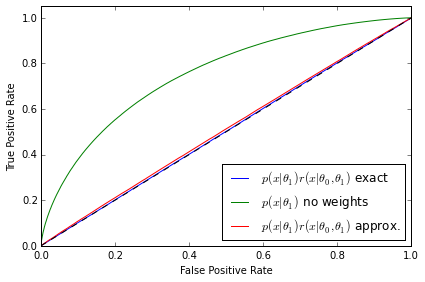

In [18]:
#fig = plt.figure(figsize=(15,15))

# I obtain data from r*p1 by resampling data from p1 using r as weights
def weight_data(x0,x1,weights):
    x1_len = x1.shape[0]
    weights = weights / weights.sum()
    weighted_data = np.random.choice(range(x1_len), x1_len, p = weights)
    w_x1 = x1.copy()[weighted_data]
    y = np.zeros(x1_len * 2)
    x_all = np.vstack((w_x1,x0))
    y_all = np.zeros(x1_len * 2)
    y_all[x1_len:] = 1
    return (x_all,y_all)

p1 = p1s[0]
X0_roc = p0.rvs(500000,random_state=777)
X1_roc = p1.rvs(500000,random_state=777)

# Roc curve comparison for p0 - r*p1
for k,param in enumerate(clf_parameters):
    #fig.add_subplot(3,2,(k+1)*2)

    clf = clfs[3*k]
    n_samples = param[1]
    X0 = p0.rvs(n_samples)
    X1 = p1.rvs(n_samples,random_state=777)
    X_len = X1.shape[0]
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    X = np.vstack((X0, X1))
    y = np.zeros(len(X))
    y[len(X0):] = 1

    ratio.fit(X, y)

    # Weighted with true ratios
    true_r = p0.pdf(X1_roc) / p1.pdf(X1_roc)
    true_r[np.isinf(true_r)] = 0.
    true_weighted = weight_data(X0_roc,X1_roc,true_r)
    # Weighted with approximated ratios
    app_r = ratio.predict(X1_roc,log=False)
    app_r[np.isinf(app_r)] = 0.
    app_weighted = weight_data(X0_roc,X1_roc,app_r)

    clf_true = MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)
    clf_true.fit(true_weighted[0],true_weighted[1])
    predicted_true = clf_true.predict(true_weighted[0])
    fpr_t,tpr_t,roc_auc_t = makeROC(predicted_true, true_weighted[1])
    plt.plot(fpr_t, tpr_t, label=r"$p(x|\theta_1)r(x|\theta_0,\theta_1)$ exact" % roc_auc_t)

    clf_true.fit(np.vstack((X0_roc,X1_roc)),true_weighted[1])
    predicted_true = clf_true.predict(np.vstack((X0_roc,X1_roc)))
    fpr_f,tpr_f,roc_auc_f = makeROC(predicted_true, true_weighted[1])
    plt.plot(fpr_f, tpr_f, label=r"$p(x|\theta_1)$ no weights" % roc_auc_f)

    clf_true.fit(app_weighted[0],app_weighted[1])
    predicted_true = clf_true.predict(app_weighted[0])
    fpr_a,tpr_a,roc_auc_a = makeROC(predicted_true, app_weighted[1])
    plt.plot(fpr_a, tpr_a, label=r"$p(x|\theta_1)r(x|\theta_0,\theta_1)$ approx." % roc_auc_a)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.tight_layout()

    plt.savefig('ROC_comp{0}.pdf'.format(k))
    plt.show()
    
#plt.tight_layout()
#plt.savefig('all_comp.pdf'.format(k))

The ROC curves tell a
similarly revealing story. As expected, the classifier is not able to
distinguish between the distributions when $p(\mathbf{x}|\theta_1)$ is weighted
by the exact likelihood ratio. We can also rule out that this is a deficiency in
the classifier because the two distributions are well separated when no weights
are applied to $p(\mathbf{x}|\theta_1)$. In both the first and second examples the ROC curve correctly diagnoses deficiencies in the
approximate likelihood ratio  $\hat{r}(\hat{s}(\mathbf{x}; \theta_0,
\theta_1))$. Finally, third example shows that the ROC curve in the well
trained, well calibrated case is almost identical with the exact likelihood
ratio, confirming the quality of the approximation.